# Assignment 2

#### Student ID: *Double click here to fill the Student ID*

#### Name: *Double click here to fill the name*

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from tensorflow.keras import layers

## Q1: Temperature forecasting

In this question, we will tackle the prediction problem of a multivariate time series. We will use the Jena Climate dataset recorded by the
[Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/wetter/). In this dataset, 14 different quantities (such as temperature, pressure, humidity, wind direction, and so on) were recorded every 10 minutes over several years. We will only use a subset of features to speed up the training:

Index| Features      |Format             |Description
-----|---------------|-------------------|-----------------------
1    |Date Time      |01.01.2009 00:10:00|Date-time reference
2    |p (mbar)       |996.52             |The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3    |T (degC)       |-8.02              |Temperature in Celsius
4    |Tpot (K)       |265.4              |Temperature in Kelvin
5    |Tdew (degC)    |-8.9               |Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6    |rh (%)         |93.3               |Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
7    |VPmax (mbar)   |3.33               |Saturation vapor pressure
8    |VPact (mbar)   |3.11               |Vapor pressure
9    |VPdef (mbar)   |0.22               |Vapor pressure deficit
10   |sh (g/kg)      |1.94               |Specific humidity
11   |H2OC (mmol/mol)|3.12               |Water vapor concentration
12   |rho (g/m ** 3) |1307.75            |Airtight
13   |wv (m/s)       |1.03               |Wind speed
14   |max. wv (m/s)  |1.75               |Maximum wind speed
15   |wd (deg)       |152.3              |Wind direction in degrees
 

The exact formulation of the problem is as follows: **Try to predict the temperature 24 hours in the future, given a time series of hourly measurements of quantities recorded over the past 5 days** by a set of sensors. 


Hint: Notice that the Recurrent models with very few parameters, like the ones in this assignment, tend to be significantly faster on a multicore CPU than on GPU because they only involve small matrix multiplications, and the chain of multiplications is not well parallelizable due to the presence of a for loop (But larger RNNs can significantly benefit from a GPU runtime). Therefore, try to train with 1 or 2 epochs to test the correctness of your code before training it with larger epochs. 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from tensorflow.keras import layers

df = pd.read_csv("../input/climate222/climate.csv")

# Select a subset of features as our predictor (Notice the predictor contains temperature) and temperature as our target
temperature = df.iloc[:,2]
raw_data = df.iloc[:,[1, 2, 6, 8, 9, 11, 12]]

# We’ll use the first 20% of the data for training, the following 20% for validation, and the last 60% for testing
num_train_samples = int(0.2 * len(raw_data))
num_val_samples = int(0.2 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

# Normalize the data
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

# Use timeseries_dataset_from_array() to generate input and target on the fly
# `sampling_rate = 6`— Observations will be sampled at one data point per hour: we will only keep one data point out of 6.
# `seq_length = 120`— Observations will go back 5 days (120 hours).
# `delay = sampling_rate * (sequence_length + 24 - 1)`— The target for a sequence will be the temperature 24 hours after the end of the sequence.

sampling_rate = 6
seq_length = 120
delay = sampling_rate * (seq_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=seq_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=seq_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=seq_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

2022-05-10 08:02:45.325819: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 08:02:45.419977: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 08:02:45.420772: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 08:02:45.423013: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [ ]:
# The function can be used to see your prediction
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

In [ ]:
for samples, targets in train_dataset:
  print("samples shape:", samples.shape)
  print("targets shape:", targets.shape)
  break

2022-05-10 08:02:48.000079: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


samples shape: (256, 120, 7)
targets shape: (256,)


(a) Try to predict the temperature 24 hours later using the naive approach (i.e., the temperature 24 hours from now will be equal to the temperature right now). Report the Mean absolute error (MAE) in the unit of degrees Celsius. (5%)

Hint: Refer to https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array for more details

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.68
Test MAE: 2.57


(b) Build an RNN with one layer of 16 simple cells, followed by a dense layer with a single neuron in the output layer. Train the model for 10 epochs with Mean square error (MSE) loss. 

Try to manually calculate the number of parameters in your model's architecture and compare it with the one reported by `summary()`. Finally, plot the learning curves (validation and training loss vs. epochs) and report the MAE on the test set in the unit of degrees Celsius.

Number of parametrs are in the comments

In [ ]:
inputs = keras.Input(shape=(seq_length, raw_data.shape[-1]))
x = layers.SimpleRNN(16)(inputs) #7*16+16+16*16
outputs = layers.Dense(1)(x) #16*1+1
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("Q1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 7)]          0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 16)                384       
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
326/326 [==============================] - 55s 163ms/step - loss: 77.2049 - mae: 6.9348 - val_loss: 32.4871 - val_mae: 4.3902
Epoch 2/10
326/326 [==============================] - 53s 163ms/step - loss: 27.2758 - mae: 3.8593 - val_loss: 15.6451 - val_mae: 3.0011
Epoch 3/10
326/326 [==============================] - 53s 161ms/step - loss: 13.7721 - mae: 2.8220 - val_loss: 11.9184 - val_mae: 2.6644
Epoch 4/10
326/326 [==============================] - 54s 164ms/step - loss: 10.6541 - mae: 2.5560 - val_loss: 11.5542 - val_mae: 2.6194
Epoch 5/10
326/326 [==============================] - 53s 163ms/step - loss: 10.0619 - mae: 2.4928 - val_loss: 11.5945 - val_mae: 2.6217
Epoch 6/10
326/326 [==============================] - 53s 161ms/step - loss: 9.8497 - mae: 2.4675 - val_loss: 11.6000 - val_mae: 2.6271
Epoch 7/10
326/326 [==============================] - 53s 163ms/step - loss: 9.6901 - mae: 2.4445 - val_loss: 11.6803 - val_mae: 2.6454
Epoch 8/10
326/326 [=======================

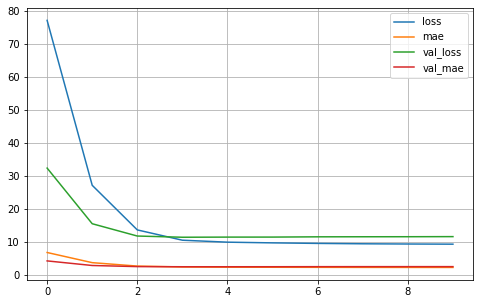

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [ ]:
model = keras.models.load_model("Q1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

980/980 [==============================] - 42s 42ms/step - loss: 10.6829 - mae: 2.5296
Test MAE: 2.53


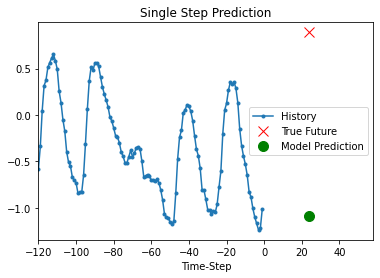

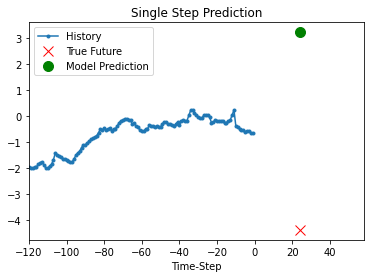

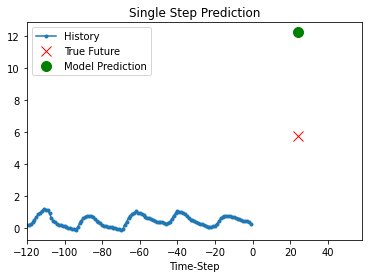

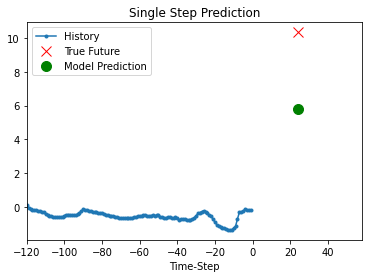

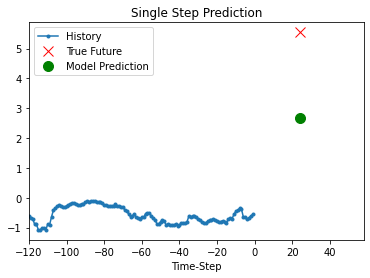

In [ ]:
for x, y in val_dataset.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        24,
        "Single Step Prediction",
    )

(c) Build an RNN with two layers of GRU with 16 cells in each layer, followed by a dense layer with a single neuron in the output layer. In addition, apply the dropout for the input units of the dense layer. The dropout rate should be set to 0.5. Train the model for 10 epochs with MSE loss. 

Finally, plot the learning curves and report the MAE on the test set in the unit of degrees Celsius.

In [ ]:
inputs = keras.Input(shape=(seq_length, raw_data.shape[-1]))
x = layers.GRU(16, return_sequences=True)(inputs)
x = layers.GRU(16)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 7)]          0         
_________________________________________________________________
gru (GRU)                    (None, 120, 16)           1200      
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                1632      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 2,849
Trainable params: 2,849
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("Q1_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10


2022-05-10 08:16:30.164602: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


326/326 [==============================] - 30s 81ms/step - loss: 64.1629 - mae: 6.0390 - val_loss: 26.7477 - val_mae: 3.9354
Epoch 2/10
326/326 [==============================] - 26s 78ms/step - loss: 29.2777 - mae: 3.9807 - val_loss: 14.2904 - val_mae: 2.9180
Epoch 3/10
326/326 [==============================] - 26s 78ms/step - loss: 20.1941 - mae: 3.3800 - val_loss: 11.8505 - val_mae: 2.6988
Epoch 4/10
326/326 [==============================] - 26s 79ms/step - loss: 17.9619 - mae: 3.2299 - val_loss: 11.6163 - val_mae: 2.6792
Epoch 5/10
326/326 [==============================] - 26s 78ms/step - loss: 17.0528 - mae: 3.1514 - val_loss: 11.4291 - val_mae: 2.6466
Epoch 6/10
326/326 [==============================] - 26s 78ms/step - loss: 16.6185 - mae: 3.1103 - val_loss: 11.1596 - val_mae: 2.6185
Epoch 7/10
326/326 [==============================] - 26s 79ms/step - loss: 16.0576 - mae: 3.0562 - val_loss: 11.2161 - val_mae: 2.6145
Epoch 8/10
326/326 [==============================] - 26s 7

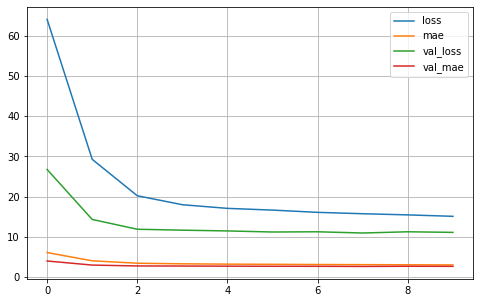

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [ ]:
model = keras.models.load_model("Q1_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

980/980 [==============================] - 37s 37ms/step - loss: 10.0648 - mae: 2.4695
Test MAE: 2.47


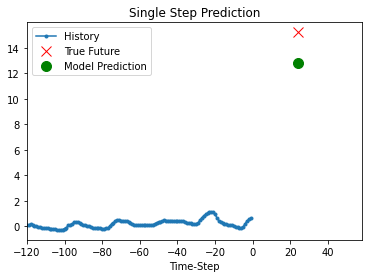

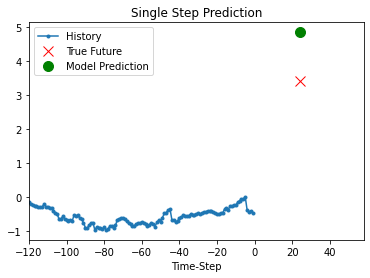

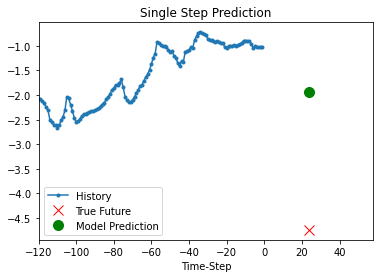

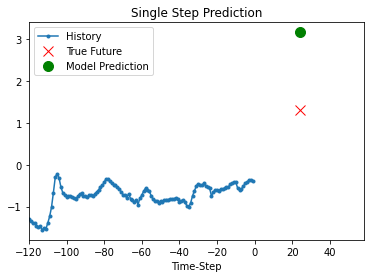

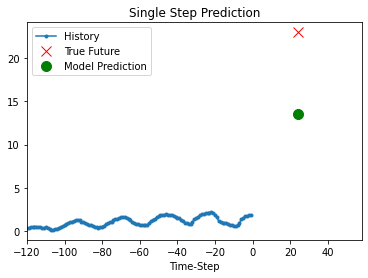

In [ ]:
for x, y in val_dataset.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        24,
        "Single Step Prediction",
    )

(d) Build an RNN as in (c). But this time, also apply the dropout to the hidden state at each time step and try to **unroll the RNN during training**. The dropout rate should be set to 0.5. Train the model for **one** epoch with MSE loss.  (5%)

Report the time required to train the network compared with (c) and make some comments on it.

Hint: Look up the document https://keras.io/api/layers/recurrent_layers/gru/ to see how to apply dropout and unroll the loop of RNN.

In [ ]:
inputs = keras.Input(shape=(seq_length, raw_data.shape[-1]))
x = layers.GRU(16, recurrent_dropout=0.5, return_sequences=True, unroll=True)(inputs)
x = layers.GRU(16, recurrent_dropout=0.5, unroll=True)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 120, 7)]          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 120, 16)           1200      
_________________________________________________________________
gru_3 (GRU)                  (None, 16)                1632      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 2,849
Trainable params: 2,849
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("Q1_gru_unroll.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=1,
                    validation_data=val_dataset,
                    callbacks=callbacks)

326/326 [==============================] - 215s 317ms/step - loss: 60.2689 - mae: 5.8980 - val_loss: 24.1868 - val_mae: 3.7291


**Ans:** When using a Keras LSTM or GRU layer on GPU with default keyword arguments, your layer will be leveraging a cuDNN kernel, a highly optimized, low-level, NVIDIA-provided implementation of the underlying algorithm. However, recurrent dropout isn’t supported by the LSTM and GRU cuDNN kernels, so adding it to your layers forces the runtime to fall back to the regular TensorFlow implementation, which is generally two to five times slower on GPU (even though its computational cost is the same). 

As a way to speed up your RNN layer when you can’t use cuDNN, you can try unrolling it. Unrolling a for loop consists of removing the loop and simply inlining its content N times. In the case of the for loop of an RNN, unrolling can help TensorFlow optimize the underlying computation graph.

## Q2: Test classification using the preprocessed IMDB dataset

In this question, we will continue to work with the IMDB dataset: a set of 50,000 highly polarized reviews from the Internet Movie Database. It consists of 50% negative and 50% positive reviews. **Our job is trying to classify the reviews into positive or negative classes.** We will focus on the model building, training, and evaluation part. Therefore, we will use the preprocessed dataset from Keras.

https://ai.stanford.edu/~amaas/data/sentiment/.

(a) Load the IMDB dataset with `keras.datasets.imdb.load_data()` and only keep the top 10,000 most frequently occurring words in the training data. In addition, split it into a training set (25,000 images), a validation set (5,000 images), and a test set (20,000 images). Finally, pad or truncate the input sequence to 500 words. (5%)

Hint: You may find https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences and https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data helpful.

In [ ]:
from sklearn.model_selection import train_test_split
(X_train, y_train), (test_data_full, test_labels_full) = keras.datasets.imdb.load_data(num_words=10000)
X_test, X_val, y_test, y_val = train_test_split(test_data_full, test_labels_full, test_size=0.2, random_state=42)

17473536/17464789 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_sequence_length = 500
# Pad all sequences
X_train = pad_sequences(X_train, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>
X_val = pad_sequences(X_val, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>
X_test = pad_sequences(X_test, maxlen=max_sequence_length, value = 0.0)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((25000, 500), (5000, 500), (20000, 500))

(b) Build a 1D Convolutional Neural Network using the following architecture and remember to mask your input in the embedding layer (Remember that the embedding layer is capable of generating a“mask” that corresponds to its input data as described in the laboratory): 


|        | Type                | Maps    | Activation | Notice|
|--------|---------------------|---------|------------|------------|
| Output | Fully connected     |       | Sigmoid    ||
| D3     | Dropout         | |  |with dropout rate set to 0.75|
| P1     | 1D Max Pooling         |         |            |with pooling size set to 2|
| D2     | Dropout |         |            |with dropout rate set to 0.75|
| C1     | 1D Convolution         | 32      | ReLu       |with kernel size set to 4, stride set to 2 and apply same padding|
| D1     | Dropout |         |            |with dropout rate set to 0.75|
| E1     | Embedding         |       |        | Output of embedding is set to 128 dimension|
| In     | Input               |  |            |Input is truncated to 500 words with 10,000 dimension|

Train the model for 10 epochs with Adam optimizer. Finally, plot the learning curves and report the accuracy on the test set.

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Embedding(10000, 128, input_length=max_sequence_length, mask_zero=True))
model.add(keras.layers.Dropout(0.75))
model.add(keras.layers.Conv1D(filters=32, kernel_size=4, strides=2, padding='same', activation='relu'))
model.add(keras.layers.Dropout(0.75))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.75))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          1280000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 128)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 250, 32)           16416     
_________________________________________________________________
dropout_3 (Dropout)          (None, 250, 32)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 125, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 4000)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4000)              0

In [ ]:
history = model.fit(X_train, y_train,
            epochs=10,
            validation_data=(X_val, y_val))

Epoch 1/10
782/782 [==============================] - 9s 5ms/step - loss: 0.7004 - accuracy: 0.5069 - val_loss: 0.6918 - val_accuracy: 0.5574
Epoch 2/10
782/782 [==============================] - 4s 5ms/step - loss: 0.6822 - accuracy: 0.5501 - val_loss: 0.6198 - val_accuracy: 0.7382
Epoch 3/10
782/782 [==============================] - 4s 5ms/step - loss: 0.4979 - accuracy: 0.7571 - val_loss: 0.3607 - val_accuracy: 0.8686
Epoch 4/10
782/782 [==============================] - 4s 5ms/step - loss: 0.3851 - accuracy: 0.8351 - val_loss: 0.3152 - val_accuracy: 0.8796
Epoch 5/10
782/782 [==============================] - 4s 5ms/step - loss: 0.3408 - accuracy: 0.8563 - val_loss: 0.3019 - val_accuracy: 0.8842
Epoch 6/10
782/782 [==============================] - 4s 5ms/step - loss: 0.3144 - accuracy: 0.8710 - val_loss: 0.3004 - val_accuracy: 0.8786
Epoch 7/10
782/782 [==============================] - 4s 5ms/step - loss: 0.3032 - accuracy: 0.8750 - val_loss: 0.2953 - val_accuracy: 0.8800
Epoch 

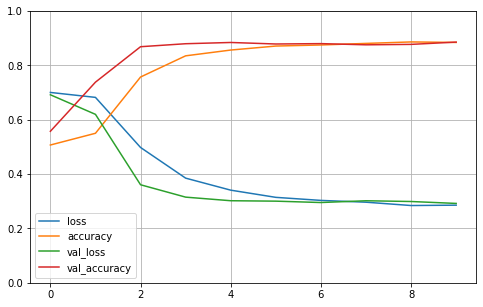

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
print(f"Test acc: {model.evaluate(X_test, y_test)[1]:.3f}")

625/625 [==============================] - 1s 2ms/step - loss: 0.2910 - accuracy: 0.8844
Test acc: 0.884


(c) There is a [rule of thumb](https://developers.google.com/machine-learning/guides/text-classification/step-2-5#algorithm_for_data_preparation_and_model_building) that you should pay close attention to the **ratio between the number of samples in your training data and the mean number of words per sample** when approaching a new text classification task. If that ratio is smaller or less than 1,500, the bag-of-bigrams model will perform better (and as a bonus, it will be much faster to train and iterate on too). If that ratio is higher than 1,500, you should go with a sequence model. In other words, sequence models work best when lots of training data are available and when each sample is relatively short. 

Try to plot the Histogram of the number of words per sample for the IMDB training dataset and calculate the ratio described above. Finally, compare the accuracy we get using bag-of-bigrams in the laboratory and the results you get in (b). Make some comments on the rule of thumb.

In [ ]:
def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.
    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

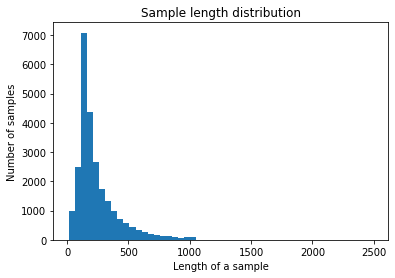

In [ ]:
(X_train, y_train), (test_data_full, test_labels_full) = keras.datasets.imdb.load_data(num_words=10000)
plot_sample_length_distribution(X_train)

In [ ]:
num_words = [len(s) for s in X_train]

In [ ]:
ratio = 25000/np.array(num_words).mean()

In [ ]:
np.array(num_words).mean()

238.71364

In [ ]:
ratio

83.78239299606005

**Ans:** We had 25,000 training samples and an average word count of 239, so our rule of thumb points toward a bigram model, which confirms what we found
in practice where we achieve 89.5% test accuracy using bag-of-word model in the laboratory.

This intuitively makes sense: the input of a sequence model represents a richer and more complex space, and thus it takes more data to map out that space; meanwhile, a plain set of terms is a space so simple that you can train a simple model on top using just a few hundreds or thousands of samples. In addition, the shorter a sample is, the less the model can afford to discard any of the information it contains in particular, word order becomes more important, and discarding it can create ambiguity.  With a longer sample, word statistics would become more reliable and the topic or sentiment would be more apparent from the word histogram alone.

## Q3: Transfer learning and network architecture search for CIFAR-10 dataset


In this question, we will try to boost the classification performance on the CIFAR-10 dataset. The techniques will include transfer learning and network architecture search.

https://www.cs.toronto.edu/~kriz/cifar.html.

(a) Firstly, Load the CIFAR-10 dataset (you may refer to `keras.datasets.cifar10.load_data()`) as in Assignment 1, and split it into a training set (45,000 images), a validation set (5,000 images) and a test set (10,000 images). (5%)

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train_full = X_train_full.astype(np.float32) 
X_test = X_test.astype(np.float32) 
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

170508288/170498071 [==============================] - 6s 0us/step


In [ ]:
X_train.shape, X_valid.shape, X_test.shape

((45000, 32, 32, 3), (5000, 32, 32, 3), (10000, 32, 32, 3))

(b) EfficientNet is a modern convnets obtained from network architecture search. Use the convolutional base of `efficientnetB0` and pretrained weight from ImageNet. Try to freeze all the variables in the convolutional base. In addition, add a dropout layer with a dropout rate set to 0.5 followed by a dense layer with softmax activation.

Train the model for 10 epochs using SGD optimizer with a learning rate of 0.01. Finally, plot the learning curves and report the accuracy on the test set.

In [ ]:
conv_base  = tf.keras.applications.EfficientNetB0(
    weights="imagenet",
    input_shape=(32, 32, 3),
    include_top=False,
    classes=10)
conv_base.trainable = False

In [ ]:
inputs = keras.Input(shape=(32, 32, 3))
# Apply input value scaling.
x = keras.applications.efficientnet.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1, 1, 1280)        4049571   
_________________________________________________________________
flatten_3 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=0.01),
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="transfer_learning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(X_train, y_train,
            epochs=10,
            validation_data=(X_valid, y_valid))

Epoch 1/10
1407/1407 [==============================] - 31s 18ms/step - loss: 1.9182 - accuracy: 0.3171 - val_loss: 1.6446 - val_accuracy: 0.4424
Epoch 2/10
1407/1407 [==============================] - 23s 17ms/step - loss: 1.7043 - accuracy: 0.3987 - val_loss: 1.5401 - val_accuracy: 0.4750
Epoch 3/10
1407/1407 [==============================] - 23s 17ms/step - loss: 1.6450 - accuracy: 0.4210 - val_loss: 1.4855 - val_accuracy: 0.4914
Epoch 4/10
1407/1407 [==============================] - 23s 17ms/step - loss: 1.6073 - accuracy: 0.4326 - val_loss: 1.4559 - val_accuracy: 0.4980
Epoch 5/10
1407/1407 [==============================] - 24s 17ms/step - loss: 1.5790 - accuracy: 0.4446 - val_loss: 1.4297 - val_accuracy: 0.5098
Epoch 6/10
1407/1407 [==============================] - 23s 16ms/step - loss: 1.5675 - accuracy: 0.4475 - val_loss: 1.4097 - val_accuracy: 0.5170
Epoch 7/10
1407/1407 [==============================] - 23s 17ms/step - loss: 1.5508 - accuracy: 0.4526 - val_loss: 1.3984 -

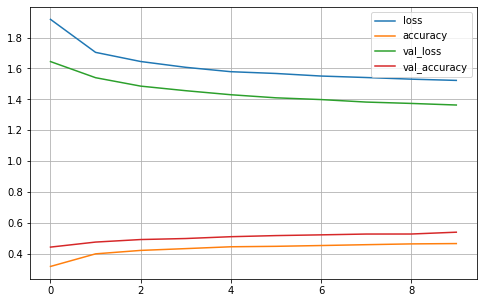

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [ ]:
print(f"Test acc: {model.evaluate(X_test, y_test)[1]:.3f}")

313/313 [==============================] - 5s 15ms/step - loss: 1.3944 - accuracy: 0.5220
Test acc: 0.522


(c) Use the same architecture as (b), but this time unfreeze all the layers (i.e.  We will fine-tune all the layers!). Train the model for 10 epochs using SGD optimizer with a learning rate of 0.01. Finally, plot the learning curves and report the accuracy on the test set. Compared the results with (a) and made some comments.

In [ ]:
conv_base  = tf.keras.applications.EfficientNetB0(
    weights="imagenet",
    input_shape=(32, 32, 3),
    include_top=False,
    classes=10)

inputs = keras.Input(shape=(32, 32, 3))
# Apply input value scaling.
x = keras.applications.efficientnet.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)
model = keras.Model(inputs, outputs)




model.compile(loss="sparse_categorical_crossentropy",
            optimizer=keras.optimizers.SGD(learning_rate=0.01),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="finetuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(X_train, y_train,
            epochs=10,
            validation_data=(X_valid, y_valid))

Epoch 1/10
1407/1407 [==============================] - 74s 47ms/step - loss: 1.6338 - accuracy: 0.4546 - val_loss: 1.0691 - val_accuracy: 0.6256
Epoch 2/10
1407/1407 [==============================] - 65s 46ms/step - loss: 1.0522 - accuracy: 0.6387 - val_loss: 0.8104 - val_accuracy: 0.7222
Epoch 3/10
1407/1407 [==============================] - 65s 46ms/step - loss: 0.8814 - accuracy: 0.6998 - val_loss: 0.7312 - val_accuracy: 0.7516
Epoch 4/10
1407/1407 [==============================] - 63s 45ms/step - loss: 0.7805 - accuracy: 0.7322 - val_loss: 0.6580 - val_accuracy: 0.7724
Epoch 5/10
1407/1407 [==============================] - 54s 38ms/step - loss: 0.7166 - accuracy: 0.7553 - val_loss: 0.6302 - val_accuracy: 0.7784
Epoch 6/10
1407/1407 [==============================] - 55s 39ms/step - loss: 0.6728 - accuracy: 0.7685 - val_loss: 0.5910 - val_accuracy: 0.7956
Epoch 7/10
1407/1407 [==============================] - 55s 39ms/step - loss: 0.6190 - accuracy: 0.7874 - val_loss: 0.5801 -

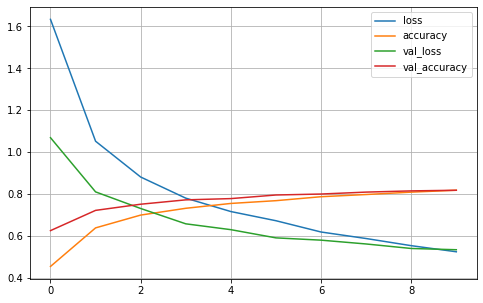

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [ ]:
print(f"Test acc: {model.evaluate(X_test, y_test)[1]:.3f}")

313/313 [==============================] - 5s 15ms/step - loss: 0.5541 - accuracy: 0.8143
Test acc: 0.814


**Ans:** In this case, the image in the CIFAR10 tends to be somewhat different from the ImageNet. Therefore, the accuracy is not good enough if we tune the final dense layer while freezing the convolutional base. On the other hand, if we can use the weight of ImageNet as a starting point and finetune all the layers, the accuracy improves a lot. This demonstrates that the high-level or low-level feature needed to differentiate CIFAR10 classes is slightly different from the original ImageNet.

(d) Use Keras Tuner to do the network architecture search. The search space is described as follows:

|        | Type                | Activation | Notice|
|--------|---------------------|---------|------------|
| Output | Fully connected    | Softmax    ||
| D1 | DropOut     |        ||
| F1     | Fully connected         | ReLu ||
| PN     | Global average pooling              |            ||
| ...     |  |                  |The convoltion blocks may repeat 3~5 times|
| P1     | Max pooling     |------------|\||
| R2     | ReLu         ||\||
| B2     | batch normalization ||\||
| C2     | Convolution     ||\|-------> These 7 layer forms 1 convolution blocks|
| R1     | ReLu         ||\||
| B1     | batch normalization ||\||
| C1     | Convolution      |------------|\||
| In     | Input         |           ||


1. Search the number of convolutional blocks (a single block contains seven layers: (convolution, batch normalization, relu)*2 followed by a pooling layer) from 3 to 5.
2. Search the number of filters used in convolutional layers in the convolutional blocks from 32 to 256 with step size set to 32
3. Search the number of neurons in the first dense layer from 30 to 100 with step size set to 10
4. Search the dropout rate from 0 to 0.5 with the step size set to 0.1.
5. Use the Adam optimizer and search the learning rate from 0.0001 to 0.01 with sampling strategy set to "log".

Use Bayesian optimization to search for a maximum of 3 trials with two executions per trial. To speed up the search, **only includes the first 1000 images from the training set** but evaluate the performance on the whole validation set for 10 epochs.

Finally, report the architecture you find.

In [ ]:
!pip install keras-tuner -q
!pip install autokeras -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tfx-bsl 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tfx-bsl 1.5.0 requires numpy<1.20,>=1.16, but you have numpy 1.20.3 which is incompatible.
tfx-bsl 1.5.0 requires pyarrow<6,>=1, but you have pyarrow 6.0.1 which is incompatible.
tensorflow-transform 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tensorflow-transform 1.5.0 requires numpy<1.20,>=1.16, but you have numpy 1.20.3 which is incompatible.
tensorflow-transform 1.5.0 requires pyarrow<6,>=1, but you have pyarrow 6.0.1 which is incompatible.
tensorflow-transform 1.5.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,<2.8,>=1.15.2, but you have tensorflow 2.8.0 which is incompat

In [ ]:
import keras_tuner as kt

def build_model(hp):
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = inputs
    for i in range(hp.Int('conv_blocks', 3, 5)):
        filters = hp.Int('filters_' + str(i), 32, 256, step=32)
        for _ in range(2):
            x = tf.keras.layers.Convolution2D(
            filters, kernel_size=(3, 3), padding='same')(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.ReLU()(x)
        #if hp.Choice('pooling_' + str(i), ['avg', 'max']) == 'max':
        x = tf.keras.layers.MaxPool2D()(x)
        #else:
        #    x = tf.keras.layers.AvgPool2D()(x)
    x = tf.keras.layers.GlobalAvgPool2D()(x)
    x = tf.keras.layers.Dense(
      hp.Int('hidden_size', 30, 100, step=10),
      activation='relu')(x)
    x = tf.keras.layers.Dropout(
      hp.Float('dropout', 0, 0.5, step=0.1))(x)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy'])
    return model

In [ ]:
tuner = kt.BayesianOptimization(
    build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    directory="ciphar10_kt",
    overwrite=True,
)

tuner.search(X_train[:1000], y_train[:1000],
             validation_data=(X_valid, y_valid),
             epochs=10)

Trial 3 Complete [00h 00m 23s]
val_accuracy: 0.3958999961614609

Best val_accuracy So Far: 0.3958999961614609
Total elapsed time: 00h 01m 27s


In [ ]:
tuner.results_summary()

Results summary
Results in ciphar10_kt/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
conv_blocks: 3
filters_0: 96
filters_1: 32
filters_2: 256
hidden_size: 100
dropout: 0.5
learning_rate: 0.0001
filters_3: 256
filters_4: 96
Score: 0.3958999961614609
Trial summary
Hyperparameters:
conv_blocks: 3
filters_0: 96
filters_1: 96
filters_2: 224
hidden_size: 100
dropout: 0.30000000000000004
learning_rate: 0.000983315988436086
Score: 0.3735000044107437
Trial summary
Hyperparameters:
conv_blocks: 5
filters_0: 96
filters_1: 96
filters_2: 64
hidden_size: 30
dropout: 0.0
learning_rate: 0.004981736647877477
filters_3: 32
filters_4: 32
Score: 0.29789999127388


In [ ]:
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model = build_model(best_hps[0])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 96)        2688      
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 96)        384       
_________________________________________________________________
re_lu_6 (ReLU)               (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 96)        83040     
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 96)        384       
_________________________________________________________________
re_lu_7 (ReLU)               (None, 32, 32, 96)        0   

(e) Train the model you find in (d) for 10 epochs on the full training set.
Finally, plot the learning curves and report the accuracy on the test set.

In [ ]:
history = model.fit(X_train, y_train,
            epochs=10,
            validation_data=(X_valid, y_valid))

Epoch 1/10
1407/1407 [==============================] - 13s 9ms/step - loss: 1.6213 - accuracy: 0.4244 - val_loss: 1.3186 - val_accuracy: 0.5204
Epoch 2/10
1407/1407 [==============================] - 12s 8ms/step - loss: 1.2153 - accuracy: 0.5749 - val_loss: 0.9930 - val_accuracy: 0.6604
Epoch 3/10
1407/1407 [==============================] - 12s 8ms/step - loss: 1.0592 - accuracy: 0.6336 - val_loss: 0.9343 - val_accuracy: 0.6730
Epoch 4/10
1407/1407 [==============================] - 12s 8ms/step - loss: 0.9583 - accuracy: 0.6674 - val_loss: 0.8532 - val_accuracy: 0.7022
Epoch 5/10
1407/1407 [==============================] - 12s 8ms/step - loss: 0.8791 - accuracy: 0.7005 - val_loss: 1.0898 - val_accuracy: 0.6316
Epoch 6/10
1407/1407 [==============================] - 11s 8ms/step - loss: 0.8092 - accuracy: 0.7224 - val_loss: 0.7766 - val_accuracy: 0.7292
Epoch 7/10
1407/1407 [==============================] - 12s 9ms/step - loss: 0.7532 - accuracy: 0.7426 - val_loss: 0.7733 - val_ac

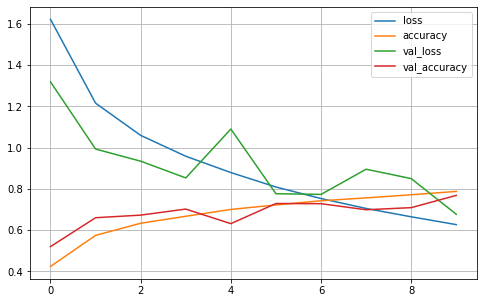

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [ ]:
print(f"Test acc: {model.evaluate(X_test, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 0.7166 - accuracy: 0.7514
Test acc: 0.751
